In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
import polars as pl

## Загрузка данных

### Датасет для прогнозирования возраста морского ушка от физических размеров

Колонки датасета:

- Sex - nominal - M, F, and I (infant)

- Length - continuous - mm - Longest shell measurement

- Diameter - continuous - mm - perpendicular to length

- Height - continuous - mm - with meat in shell

- Whole weight - continuous - grams - whole abalone

- Shucked weight - continuous - grams - weight of meat

- Viscera weight - continuous - grams - gut weight (after bleeding)

- Shell weight - continuous - grams - after being dried

- Rings - integer - +1.5 gives the age in years (target)

In [31]:
df = pd.read_csv('data/abalone.csv')
df.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,NaN,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


### Общее исследование и очистка данных

In [32]:
df.shape

(4177, 9)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4078 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4078 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4127 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [34]:
df.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,4177.000000,4078.000000,4177.000000,4078.000000,4177.000000,4177.000000,4127.000000,4177.000000
mean,0.523992,0.407840,0.139516,0.827306,0.359367,0.180594,0.239072,9.933684
std,0.120093,0.099286,0.041827,0.490348,0.221963,0.109614,0.138942,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.440500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.798500,0.336000,0.171000,0.235000,9.000000
75%,0.615000,0.480000,0.165000,1.150875,0.502000,0.253000,0.328250,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [35]:
df.describe(include='object')

,Sex
count,4177
unique,4
top,M
freq,1447


In [36]:
df.duplicated().sum()

0

In [37]:
df.isna().sum()

Sex                0
Length             0
Diameter          99
Height             0
Whole weight      99
Shucked weight     0
Viscera weight     0
Shell weight      50
Rings              0
dtype: int64

In [38]:
df[df.isna().any(axis=1)]

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
3,M,0.440,0.365,0.125,NaN,0.2155,0.1140,0.155,10
43,I,0.205,0.150,0.055,NaN,0.0255,0.0150,0.012,5
64,M,0.520,NaN,0.120,0.5800,0.2340,0.1315,0.185,8
102,M,0.530,0.435,0.160,NaN,0.3160,0.1640,0.335,15
127,I,0.385,NaN,0.085,0.2505,0.1120,0.0610,0.080,8
...,...,...,...,...,...,...,...,...,...
4128,M,0.555,0.435,0.145,NaN,0.4040,0.2275,0.255,8
4138,M,0.630,0.490,0.155,NaN,0.5350,0.2900,0.335,11
4143,F,0.655,NaN,0.220,1.3590,0.6420,0.3255,0.405,13
4163,I,0.390,NaN,0.085,0.3440,0.1810,0.0695,0.079,7


In [39]:
df_clean = df.dropna()
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3935 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             3935 non-null   object 
 1   Length          3935 non-null   float64
 2   Diameter        3935 non-null   float64
 3   Height          3935 non-null   float64
 4   Whole weight    3935 non-null   float64
 5   Shucked weight  3935 non-null   float64
 6   Viscera weight  3935 non-null   float64
 7   Shell weight    3935 non-null   float64
 8   Rings           3935 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 307.4+ KB


In [40]:
df_clean.Sex.unique()

array(['M', 'F', 'I', 'f'], dtype=object)

In [41]:
df_clean.reset_index(drop=True, inplace=True)

In [42]:
df_clean['Sex']= df_clean['Sex'].str.replace('f', 'F')

/tmp/ipykernel_12960/1685056732.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Sex']= df_clean['Sex'].str.replace('f', 'F')


In [43]:
df_clean.shape

(3935, 9)

In [44]:
df_clean['Age'] = df_clean['Rings'].apply(lambda x: x+1.5)
df_clean.head()

/tmp/ipykernel_12960/4090358814.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Age'] = df_clean['Rings'].apply(lambda x: x+1.5)


,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Age
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,16.5
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,8.5
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,10.5
3,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,8.5
4,I,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8,9.5


### Однофакторный анализ

#### Гистограммы распределений

/tmp/ipykernel_12960/2303620777.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_clean.hist(ax=ax)


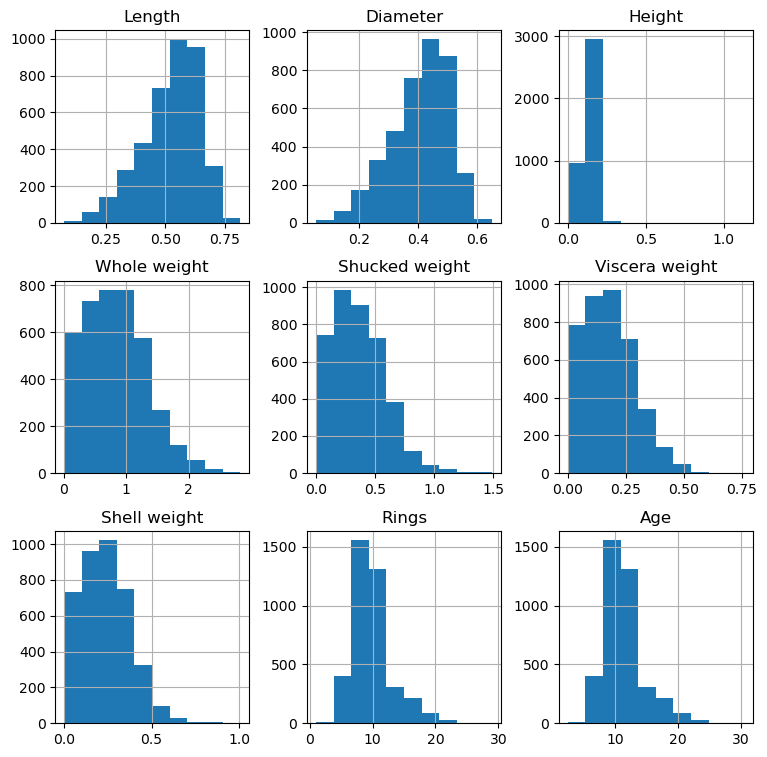

In [45]:
fig = plt.figure(figsize=(9, 9))
ax = fig.gca()
df_clean.hist(ax=ax)
plt.show()

/tmp/ipykernel_12960/1073590910.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_clean[df_clean['Sex']=='M'].hist(ax=ax)


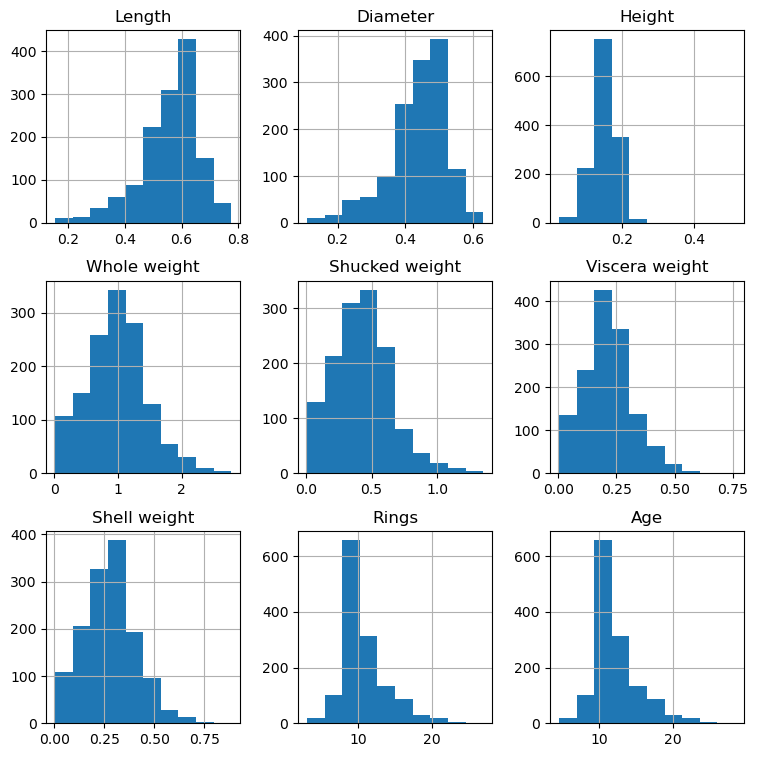

In [46]:
fig = plt.figure(figsize=(9, 9))
ax = fig.gca()
df_clean[df_clean['Sex']=='M'].hist(ax=ax)
plt.show()

/tmp/ipykernel_12960/2522739738.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_clean[df_clean['Sex']=='F'].hist(ax=ax)


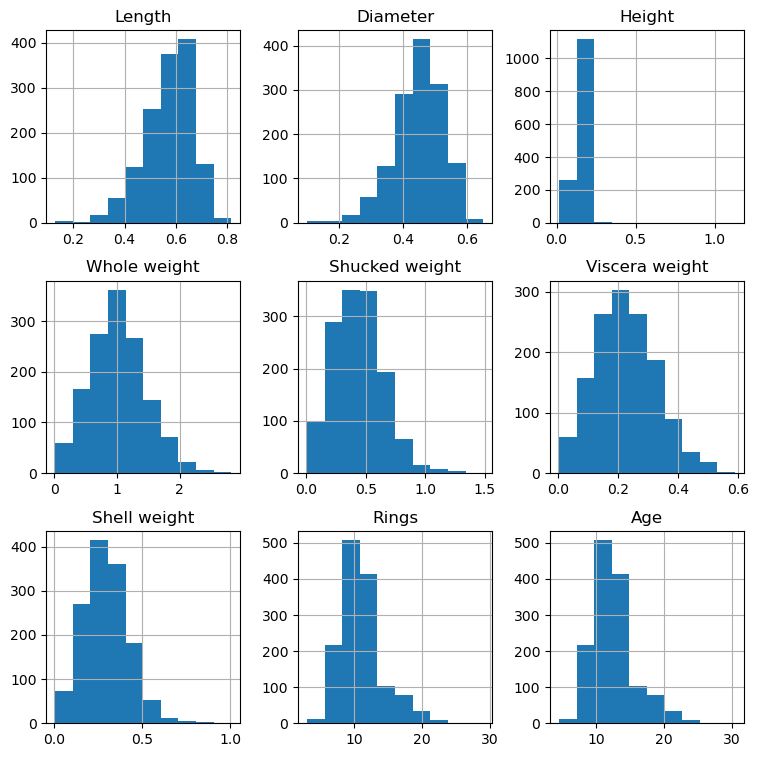

In [47]:
fig = plt.figure(figsize=(9, 9))
ax = fig.gca()
df_clean[df_clean['Sex']=='F'].hist(ax=ax)
plt.show()

/tmp/ipykernel_12960/575641855.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_clean[df_clean['Sex']=='I'].hist(ax=ax)


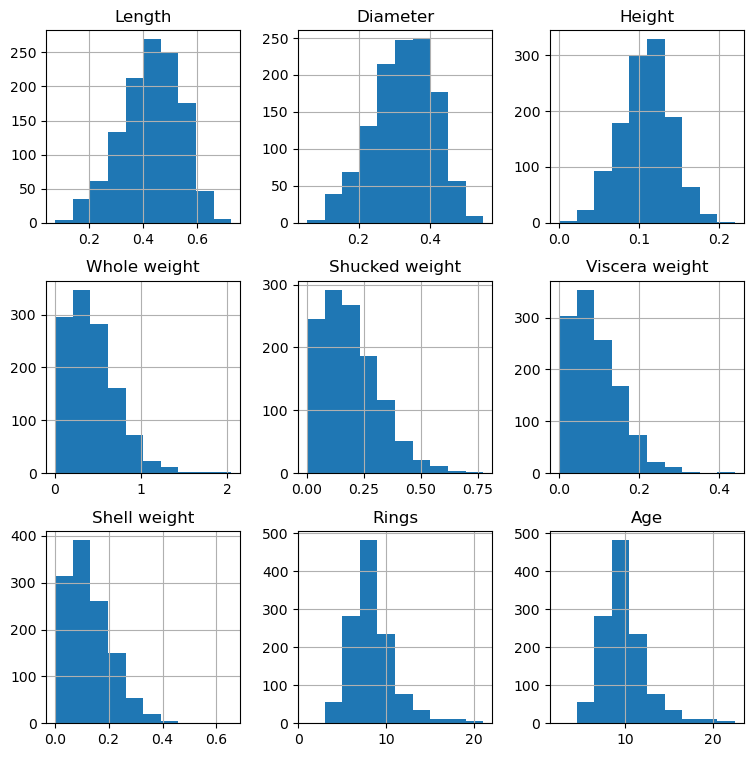

In [48]:
fig = plt.figure(figsize=(9, 9))
ax = fig.gca()
df_clean[df_clean['Sex']=='I'].hist(ax=ax)
plt.show()

### Выводы

Распределение целевого параметра - унимодальное с утяжеленным хвостом справа

#### Средние и медианные значения в зависимости от пола

In [49]:
df_clean.groupby('Sex').agg(
    LengthMean=('Length', 'mean'),
    DiameterMean=('Diameter', 'mean'),
    HeightMean=('Height', 'mean'),
    WholeWeightMean=('Whole weight', 'mean'),
    ShuckedWightMean=('Shucked weight', 'mean'),
    VisceraWeightMean=('Viscera weight', 'mean'),
    ShellWeightMean=('Shell weight', 'mean'),
    AgeMean=('Age', 'mean')
).sort_values('LengthMean', ascending=False)

,LengthMean,DiameterMean,HeightMean,WholeWeightMean,ShuckedWightMean,VisceraWeightMean,ShellWeightMean,AgeMean
Sex,,,,,,,,
F,0.572698,0.448935,0.155851,1.021776,0.436715,0.224491,0.294672,12.481818
M,0.559516,0.438062,0.150780,0.983399,0.429582,0.213895,0.279482,12.154945
I,0.427481,0.326184,0.107782,0.428647,0.189773,0.091596,0.127313,9.385356


In [50]:
df_clean.groupby('Sex').agg(
    LengthMedian=('Length', 'median'),
    DiameterMedian=('Diameter', 'median'),
    HeightMedian=('Height', 'median'),
    WholeWeightMedian=('Whole weight', 'median'),
    ShuckedWightMedian=('Shucked weight', 'median'),
    VisceraWeightMedian=('Viscera weight', 'median'),
    ShellWeightMedian=('Shell weight', 'median'),
    AgeMedian=('Age', 'median')
).sort_values('LengthMedian', ascending=False)

,LengthMedian,DiameterMedian,HeightMedian,WholeWeightMedian,ShuckedWightMedian,VisceraWeightMedian,ShellWeightMedian,AgeMedian
Sex,,,,,,,,
F,0.585,0.460,0.155,1.0075,0.4310,0.2195,0.2880,11.5
M,0.580,0.455,0.155,0.9715,0.4215,0.2095,0.2750,11.5
I,0.435,0.335,0.110,0.3820,0.1685,0.0800,0.1115,9.5


#### Корреляция данных

<Axes: >

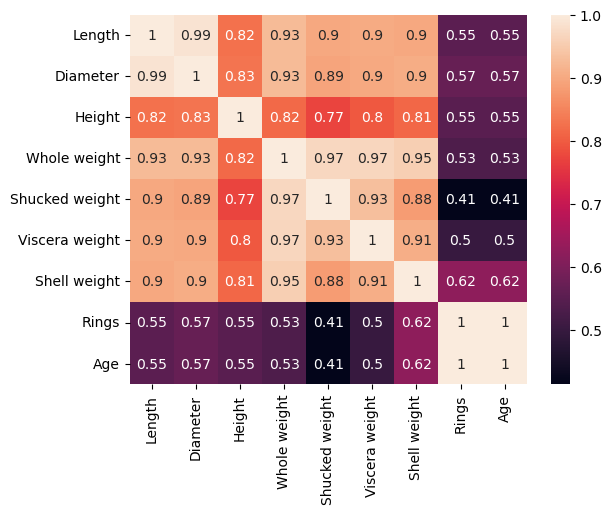

In [51]:
corr = df_clean.corr(numeric_only=True)
sns.heatmap(corr, annot=True)

<Axes: >

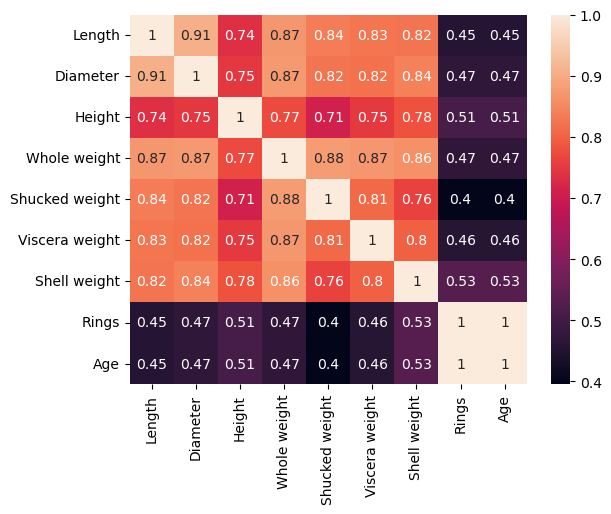

In [52]:
corr = df_clean.corr(numeric_only=True, method='kendall')
sns.heatmap(corr, annot=True)

<Axes: >

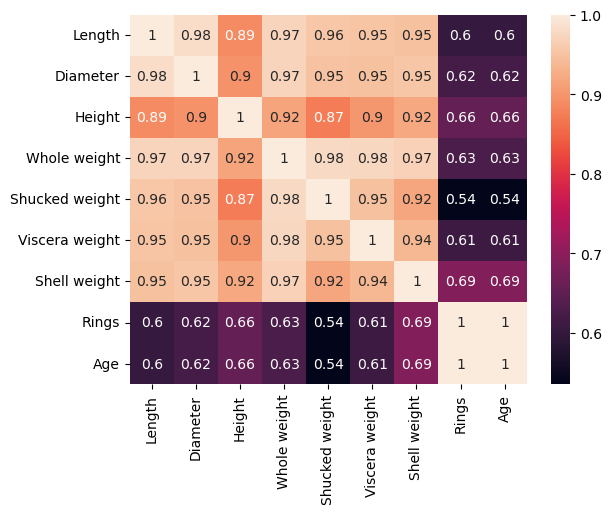

In [53]:
corr = df_clean.corr(numeric_only=True, method='spearman')
sns.heatmap(corr, annot=True)

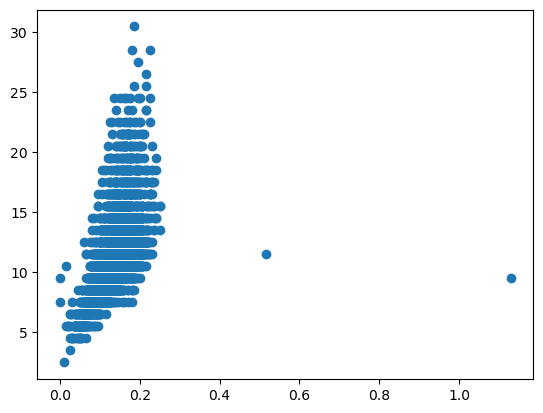

In [54]:
x = df_clean['Height']
y = df_clean['Age']
plt.scatter(x, y)
plt.show()

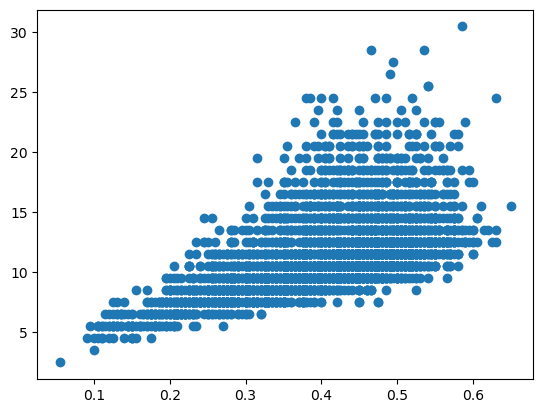

In [55]:
x = df_clean['Diameter']
y = df_clean['Age']
plt.scatter(x, y)
plt.show()

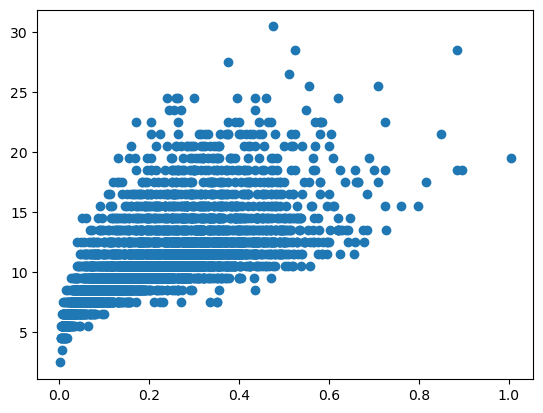

In [56]:
x = df_clean['Shell weight']
y = df_clean['Age']
plt.scatter(x, y)
plt.show()

Зависимости между параметрами и целевым показателем - нелинейные

### ANOVA

In [57]:
f_oneway(df_clean['Shell weight'][df['Sex'] == 'M'],
        df_clean['Shell weight'][df['Sex'] == 'F'],
        df_clean['Shell weight'][df['Sex'] == 'I'])

F_onewayResult(statistic=10.966620160371853, pvalue=1.7829644694741834e-05)

In [58]:
Data = []

for c1 in df_clean.columns:
    for c2 in df_clean.columns:
        if df_clean[c1].dtype == 'object' and df_clean[c2].dtype != 'object':
            CategoryGroupLists = df_clean.groupby(c1)[c2].apply(list)
            AnovaResults = f_oneway(*CategoryGroupLists)

            if AnovaResults[1] >= 0.05:
                Data.append({'Category' : c1, 'Numerical' : c2, 'Is correlated' : 'No'})
            else:
                Data.append({'Category' : c1, 'Numerical' : c2, 'Is correlated' : 'Yes'})

AnovaRes = pd.DataFrame.from_dict(Data)
AnovaRes

,Category,Numerical,Is correlated
0,Sex,Length,Yes
1,Sex,Diameter,Yes
2,Sex,Height,Yes
3,Sex,Whole weight,Yes
4,Sex,Shucked weight,Yes
5,Sex,Viscera weight,Yes
6,Sex,Shell weight,Yes
7,Sex,Rings,Yes
8,Sex,Age,Yes


### Выводы

Обнаружена взаимосвязь между полом и физическими параметрами моллюсков

### Сравнение работы библиотек Pandas и Polars

In [66]:
df_big = df_clean.copy()

for i in range(500):
  df_big = pd.concat([df_big, df])

df_big.to_csv("data/dataset_big.csv", index=False)

In [67]:
df_big.shape

(2092435, 10)

### Загрузка данных

In [68]:
%%time
df_pl = pl.read_csv('data/dataset_big.csv')

CPU times: user 2.09 s, sys: 308 ms, total: 2.4 s
Wall time: 727 ms


In [69]:
%%time
df_pd = pd.read_csv('data/dataset_big.csv')

CPU times: user 1.87 s, sys: 452 ms, total: 2.32 s
Wall time: 2.34 s


### Фильтрация данных

In [71]:
%%time
df_pd.query("Sex == 'M'")

CPU times: user 116 ms, sys: 19.5 ms, total: 135 ms
Wall time: 139 ms


,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Age
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15,16.5
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7,8.5
7,M,0.475,0.370,0.125,0.5095,0.2165,0.1125,0.1650,9,10.5
10,M,0.430,0.350,0.110,0.4060,0.1675,0.0810,0.1350,10,11.5
11,M,0.490,0.380,0.135,0.5415,0.2175,0.0950,0.1900,11,12.5
...,...,...,...,...,...,...,...,...,...,...
2092428,M,0.550,0.430,0.130,0.8395,0.3155,0.1955,0.2405,10,NaN
2092429,M,0.560,0.430,0.155,0.8675,0.4000,0.1720,0.2290,8,NaN
2092431,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10,NaN
2092432,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9,NaN


In [72]:
%%time
df_pl.filter(pl.col('Sex') == 'M')

CPU times: user 64.8 ms, sys: 39.1 ms, total: 104 ms
Wall time: 73.5 ms


Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Age
str,f64,f64,f64,f64,f64,f64,f64,i64,f64
"""M""",0.455,0.365,0.095,0.514,0.2245,0.101,0.15,15,16.5
"""M""",0.35,0.265,0.09,0.2255,0.0995,0.0485,0.07,7,8.5
"""M""",0.475,0.37,0.125,0.5095,0.2165,0.1125,0.165,9,10.5
"""M""",0.43,0.35,0.11,0.406,0.1675,0.081,0.135,10,11.5
"""M""",0.49,0.38,0.135,0.5415,0.2175,0.095,0.19,11,12.5
…,…,…,…,…,…,…,…,…,…
"""M""",0.55,0.43,0.13,0.8395,0.3155,0.1955,0.2405,10,null
"""M""",0.56,0.43,0.155,0.8675,0.4,0.172,0.229,8,null
"""M""",0.59,0.44,0.135,0.966,0.439,0.2145,0.2605,10,null


### Аггрегация данных

In [73]:
%%time
df_pd.groupby('Sex').agg({'Diameter': 'mean', 'Age': 'max'})

CPU times: user 173 ms, sys: 32.2 ms, total: 205 ms
Wall time: 208 ms


,Diameter,Age
Sex,,
F,0.454195,30.5
I,0.325738,22.5
M,0.438339,28.5
f,0.417037,NaN


In [75]:
%%time
df_pl.group_by('Sex').agg([pl.mean('Diameter'), pl.max('Age')])

CPU times: user 188 ms, sys: 48 ms, total: 236 ms
Wall time: 108 ms


Sex,Diameter,Age
str,f64,f64
"""F""",0.454195,30.5
"""M""",0.438339,28.5
"""f""",0.417037,null
"""I""",0.325738,22.5


In [78]:
%%time

q = (
    df_pl
    .lazy()
    .group_by('Sex')
    .agg(
        [
            pl.col('Diameter').mean(),
            pl.col('Age').max()
        ]
    )
)

CPU times: user 176 µs, sys: 0 ns, total: 176 µs
Wall time: 185 µs


In [79]:
%%time
q.collect()

CPU times: user 168 ms, sys: 71 ms, total: 239 ms
Wall time: 131 ms


Sex,Diameter,Age
str,f64,f64
"""M""",0.438339,28.5
"""I""",0.325738,22.5
"""F""",0.454195,30.5
"""f""",0.417037,null


### Выводы

Значительной разницы по производительности между библиотеками на выборке размером > 2_000_000 элементов не обнаружено